# The 1-Wasserstein Distance Between Persistence Diagrams
In this notebook, we will first recall the definition of the 1-Wasserstein distance between two measures. <br>
Next, we will show that persistence diagrams may be viewed as measures. Thus, we may compute the 1-Wasserstein distance between two persistence diagrams. <br>
Finally, we will use linear programming to compute the 1-Wasserstein distance between persistence diagrams in two examples. In both examples, we will sample points from a 2-manifold and use ripser to compute persistence diagrams. These examples are:
* Two samples from a sphere. We expect the 1-Wasserstein distance to be small.
* One sample from a sphere and another sample from a torus. We expect the 1-Wasserstein distance to be larger. <br>

Before I continue, I would like to make a clarifying statement. I will often use the phrase "1-Wasserstein distance" to describe the optimization problem I am solving to find the distance between persistence diagrams. However, my implementation may be more correctly described as Optimal Partial Transport. I will address this in more detail below. 

# 1-Wasserstein Distance
Recall the definition of the 1-Wasserstein distance. Let $\mu, \nu$ be measures on the same metric measure space $(M, d)$. Let $\pi$ be a coupling of $\mu, \nu$: that is, $\pi$ is a measure on the product space $M \times M$ such that $\int_{M} \pi(x, y) dy = \mu(x)$ and $\int_{M} \pi(x, y)dx = \nu(y)$. That is, $\pi$ has as marginals $\mu$ and $\nu$.

We define the 1-Wasserstein distance between $\mu$ and $\nu$, denoted $d_{W_1}(\mu, \nu)$, as $$ d_{W_1}(\mu, \nu) = \inf_{\pi} \int_{M \times M} d(x, y) d_\pi(x, y),$$
where we infimize over all possible couplings $\pi$. We will refer to $d$ as the cost function in this notebook. 

# Persistence Diagrams as Measures & Optimal Partial Transport
We can view a persistance diagram $\text{PD}$ as a measure $\mu$ in the following sense: $\mu = \sum_{x \in \text{PD}}n_x \delta_x $ where $n_x$ is the multiplicity of $x$. That is, $\mu$ is the sum of dirac measures, one for each point in our persistence diagram, multiplied by multiplicities. Let $\mathbb{W} = \{(x, y) \in \mathbb{R}^2 \; | \; x < y\}$; then, a persistence diagram is a measure supported on $\mathbb{W}$. We call $\partial \mathbb{W}$ the diagonal.

When measuring the 1-Wasserstein distance between persistence diagrams, we may wish to match points to the diagonal. Indeed, (birth, death) pairs close to the diagonal are often interpreted as noise in a dataset. These are homological features that live for a short period of time and thus are not likely to give useful information about the shape of our dataset. However, blindly applying ideas from optimal transport does not exactly describe this idea of "matching to the diagonal". Our persistence diagrams/measures are no guaranteed to have equal mass, as in the traditional setting of optimal transport/Wasserstein distances. To accomodate this, we would like to "borrow" mass from the diagonal. Thus, I will briefly introduce the concept of Optimal Partial Transport without going into too many of the details, as we will imploy ideas from Optimal Partial Transport to our computation of the 1-Wasserstein distance between persistence diagrams.

Optimal Partial Transport mainly addresses the question: how can we talk about "optimal transport" when comparing two measures of different mass? In the case of persistence diagrams, we are studying measure supported on $\overline{\mathbb{W}} \backslash \partial \mathbb{W}$. In Optimal Partial Transport, $\mu(\mathbb{W})$ and $\nu(\mathbb{W})$ need not be equal. Instead, we can push mass to or take mass from the diagonal $\partial\mathbb{W}$. I do not go into details on partial optimal transport, but instead refer you to the following three papers for more details:
* ["A new transportation distance between non-negative measures, with applications to gradient flows with Dirichlet boundary conditions"](https://cvgmt.sns.it/paper/1147/) by A. Figalli and N. Gigli.
* ["Understanding the topology and the geometry of the space of persistence diagrams via optimal partial transport"](https://arxiv.org/pdf/1901.03048.pdf) by V. Divol and T. Lacombe.
* ["Virtual persistence diagrams, signed measures, Wasserstein distances, and Banach spaces"](https://arxiv.org/pdf/2012.10514.pdf) by P. Bubenik and A. Elchesen.

# Computation
We use the ideas above, as well as linear programming tools, in order to compute the 1-Wasserstein distance between persistence diagrams.

In [1]:
# Import necessary packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from teaspoon.MakeData.PointCloud import Torus, Sphere
from scipy.optimize import linprog

# Orthogonal Projection
In order to allow for "matching to the diagonal" in our linear program, we first need to review how to find the orthogonal projection of a vector in $\mathbb{R}^2$ onto the diagonal. <br> 
Below, we will review and visualize orthogonal projections:

stupid check:
[[6.66133815e-16]]


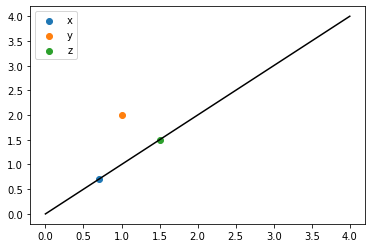

In [2]:
# My officemate Nate Mankovich helped me write this code and gave me a review on orthogonal projection. Thanks Nate!
# Take a sample point from R^2. Make sure y does not lie on the diagonal.
y = np.array([[1], [2]])

# The diagonal is the 1-dimensional subspace of R^2 spanned by the vector x below.
x = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]])

# Below we compute the orthogonal projection of y onto x.
z = x @ x.T @ y

# Plot our points for visualization purposes.
plt.plot([0,4],[0,4], color = 'k')
plt.scatter(x[0],x[1], label = 'x')
plt.scatter(y[0], y[1], label = 'y')
plt.scatter(z[0], z[1], label = 'z')
plt.legend()

# Make sure dot product is actually 0.
print('stupid check:')
print((y-z).T @ x)


# Sampling from the Sphere and the Torus
Now, we let's use linear programming to find the 1-Wasserstein distance between persistence diagrams. <br>
We will use the [teaspoon package](https://lizliz.github.io/teaspoon/) to sample from the sphere and from the torus. 

First, we consider two different samples from the sphere. 

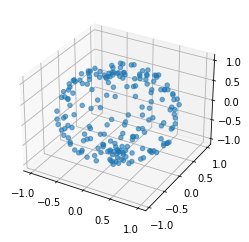

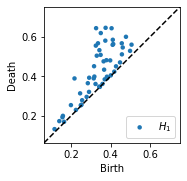

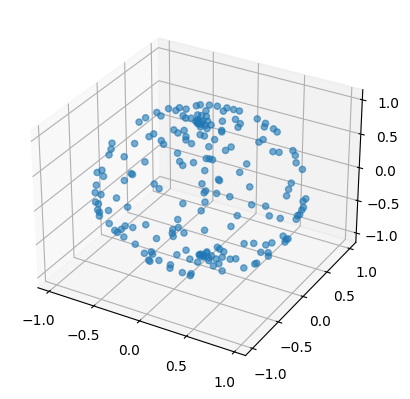

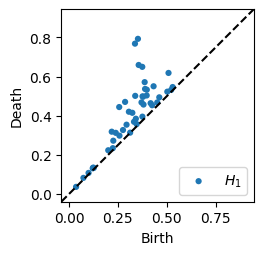

In [3]:
# Specify number of samples and number of points in each sample.
numPts = 200
numSmpls = 2

# For plotting our shapes.
cmap=mpl.colormaps['rainbow']

# Compute persistence for our samples.
# Visualize our samples.
# View the persistence diagrams for samples.
PDsSphere = []
for i in range(numSmpls):
    s = Sphere(N = numPts, seed = i+17)
    fig = plt.figure(f'plot{i}')
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(s[:,0], s[:,1], s[:,2], cmap=cmap, alpha = .6)
    plt.show()
    PDS = ripser(s,2)['dgms']
    PDsSphere.append(PDS[1])
    plt.figure(figsize=(2.5,2.5))
    plot_diagrams(PDS, plot_only=[1], show=True)

In [4]:
# PDsSphere holds both persistence diagrams. Separate.
Sphere1PD = PDsSphere[0]
Sphere2PD = PDsSphere[1]

# We want the possibility of matching to the diagonal. Thus, we project each point onto diagonal.
x = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]])
PD1project = []
PD2project = []
for i in range(len(Sphere1PD)):
    y = np.array([Sphere1PD[i][0], Sphere1PD[i][1]])
    z = x @ x.T @ y
    PD1project.append(z)
for i in range(len(Sphere2PD)):
    y = np.array([Sphere2PD[i][0], Sphere2PD[i][1]])
    x = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]])
    z = x @ x.T @ y
    z = z.tolist()
    PD2project.append(z)

Sphere1PD = Sphere1PD.tolist()
Sphere2PD = Sphere2PD.tolist()

We will use orthogonal projection to allow for matching to the diagonal. In order to allow for this, we will append the projections of our second persistence diagram to our first persistence diagram; this way, when matching points, we allow points on the second persistence diagram to match to their projection (and vice versa). 

In [5]:
Sphere1PD_Diag = Sphere1PD + PD2project
Sphere2PD_Diag = Sphere2PD + PD1project

In [6]:
# Create a function to find euclidean distance between two points.
# This will be the cost of moving one point to another.
def dist(a, b, c, d):
    return(np.sqrt((a-c)**2 + (b-d)**2))

In [7]:
# Create an array of variables.
# x_i,j = amount transported from ith point in Sphere1PD_Diag to jth point in Sphere2PD_Diag.
x = []
for i in range(len(Sphere1PD_Diag)):
    for j in range(len(Sphere2PD_Diag)):
        var = 'x_' + str(i) + ',' + str(j)
        x.append(var)

Here costs will be given by the Euclidean distance between two points. However, we need to be careful when dealing with points on the diagonal: we don't want points on the diagonal matching to each other to count towards the total cost of our matching. Thus, when building our vector c of costs, we declare that the "distance" between points on the diagonal is 0.

In [8]:
# Create array of costs.
c = []
for i in range(len(Sphere1PD)):
    # Compute distance between point in PD of sphere sample 1 to points in PD of sphere sample 2 as well as the diagonal.
    for j in range(len(Sphere2PD_Diag)):
        distance = dist(Sphere1PD[i][0], Sphere1PD[i][1], Sphere2PD_Diag[j][0], Sphere2PD_Diag[j][1])
        c.append(distance)
for i in range(len(PD2project)):
    for j in range(len(Sphere2PD_Diag)):
        # Compute distance between from diagonal to points in PD of sphere sample 2.
        if j in range(len(Sphere2PD)):
            distance = dist(PD2project[i][0], PD2project[i][1], Sphere2PD[j][0], Sphere2PD[j][1])
            c.append(distance)
        # Set cost of matching a point in the diagonal to another point in the diagonal to 0.
        if j in range(len(Sphere2PD), len(Sphere2PD_Diag)):
            c.append(0)


Recall that the measure at a point in our persistence diagram is its multiplicity. Indeed, since we are working with the persistence diagram as a list of points, the measure at each (birth, death) pair is 1. 

Theoretically, we want the diagonal to have "infinite multiplicity". In practice, however, it will not change the optimal solution to set the multiplicity of the projection of each point on the two persistence diagrams to 1. Afterall, in an optimal solution, any point matched to the diagonal will be matched to its orthogonal projection onto the diagonal.

In [9]:
# Create array with measure at each point.
total_pts = len(Sphere1PD_Diag) + len(Sphere2PD_Diag)
b = np.ones(total_pts, dtype = list)

In [10]:
# Create constraint matrix.
one_subs = []
two_subs = []
zero_matrix = np.zeros((len(Sphere2PD_Diag), len(Sphere1PD_Diag)), dtype = list)
for i in range(len(Sphere1PD_Diag)):
    zero_matrix = np.zeros((len(Sphere2PD_Diag), len(Sphere1PD_Diag)), dtype = list)
    B = zero_matrix
    B[:: , i] = 1
    one_subs.append(B)
one_subs = np.vstack(one_subs)

for i in range(len(Sphere1PD_Diag)):
    diag_matrix = np.diag(np.ones(len(Sphere2PD_Diag), dtype = list))
    two_subs.append(diag_matrix)
two_subs = np.vstack(two_subs)
 
A = np.hstack((one_subs, two_subs))


In [11]:
# Need correct types.
c = np.array(c)

Optimize! <br>
Recall that the output is the 1-Wasserstein distance between the persistence diagrams of two samples from the sphere. Thus, we expect that our optimal solution will be small. 

In [12]:
options = {"disp": False, "maxiter": 10000}
opt = linprog(c=c, A_eq=A.T, b_eq=b, method="revised simplex", options = options)
opt

/var/folders/3h/6frnxss502n097jxqmmf66l00000gn/T/ipykernel_1176/3647769840.py:2: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  opt = linprog(c=c, A_eq=A.T, b_eq=b, method="revised simplex", options = options)


     con: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])
     fun: 1.5448466582191336
 message: 'Optimization terminated successfully.'
     nit: 5550
   slack: array([], dtype=f

Next, we consider a sample from the sphere and a sample from the torus. 

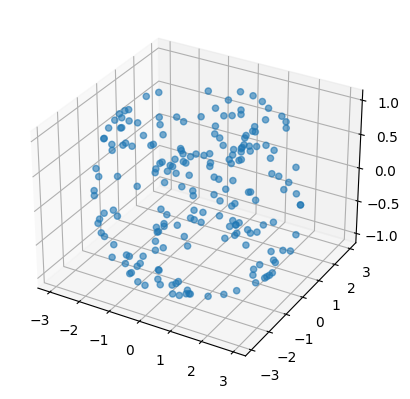

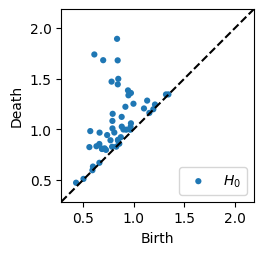

In [13]:
# Sample from the torus and visualize.
t = Torus(N = numPts, seed = 5)
fig = plt.figure(f'plot{i}')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t[:,0], t[:,1], t[:,2], cmap=cmap, alpha = .6)
plt.show()

# Compute persistence for our sample from the torus. We already have samples from the sphere.
# View the persistence diagrams for our sample.
TorusPD = ripser(t,2)['dgms']
TorusPD = TorusPD[1]
plt.figure(figsize=(2.5,2.5))
plot_diagrams(TorusPD, show=True)

# We want the possibility of matching to the diagonal. Thus, we project each point onto diagonal.
x = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]])
TorusPDproject = []
for i in range(len(TorusPD)):
    y = np.array([TorusPD[i][0], TorusPD[i][1]])
    z = x @ x.T @ y
    z = z.tolist()
    TorusPDproject.append(z)

TorusPD = TorusPD.tolist()

# Append projections to persistence diagrams to allow for matching to the diagonal.
TorusPD_Diag = TorusPD + PD1project
SpherePD_Diag = Sphere1PD + TorusPDproject


In [14]:
# Create an array of variables.
# x_i,j = amount transported from ith most persistent point in Sphere1PD_Diag to jth most persistent point in TorusPD_Diag.
x2 = []
for i in range(len(SpherePD_Diag)):
    for j in range(len(TorusPD_Diag)):
        var = 'x_' + str(i) + ',' + str(j)
        x2.append(var)

In [15]:
# Create array of costs.
# Cost = Euclidean distance in this example.
# We need to be careful, however. A point on the diagonal matched to another point on the diagonal should have zero cost.
c2 = []
for i in range(len(Sphere1PD)):
    # Compute distance between point in PD of sphere sample to points in PD of torus sample as well as the diagonal.
    for j in range(len(TorusPD_Diag)):
        distance = dist(Sphere1PD[i][0], Sphere1PD[i][1], TorusPD_Diag[j][0], TorusPD_Diag[j][1])
        c2.append(distance)
for i in range(len(TorusPDproject)):
    for j in range(len(TorusPD_Diag)):
        # Compute distance from diagonal to points in PD of torus sample.
        if j in range(len(TorusPD)):
            distance = dist(TorusPDproject[i][0], TorusPDproject[i][1], TorusPD[j][0], TorusPD[j][1])
            c2.append(distance)
        # Set cost of matching a point in the diagonal to another point in the diagonal to 0.
        if j in range(len(TorusPD), len(TorusPD_Diag)):
            c2.append(0)

# Need correct types
c2 = np.array(c2)


In [16]:
# Create array with measure at each point.
# Recall from intro that the measure is multiplicity.
# Since we just have a list of points, multiplicity = 1 for all points.
total_pts = len(SpherePD_Diag) + len(TorusPD_Diag)
b2 = np.ones(total_pts, dtype = list)

In [17]:
# Create constraint matrix.
one_subs2 = []
two_subs2 = []
zero_matrix = np.zeros((len(SpherePD_Diag), len(TorusPD_Diag)), dtype = list)
for i in range(len(SpherePD_Diag)):
    zero_matrix = np.zeros((len(TorusPD_Diag), len(SpherePD_Diag)), dtype = list)
    B = zero_matrix
    B[:: , i] = 1
    one_subs2.append(B)
one_subs2 = np.vstack(one_subs2)

for i in range(len(SpherePD_Diag)):
    diag_matrix = np.diag(np.ones(len(TorusPD_Diag), dtype = list))
    two_subs2.append(diag_matrix)
two_subs2 = np.vstack(two_subs2)
 
A2 = np.hstack((one_subs2, two_subs2))


Optimize! <br>
Recall that the output is the 1-Wasserstein distance between the persistence diagrams of a sample from the sphere and a sample from the torus. Thus, we expect that our optimal solution will be larger than previously. 

In [18]:
options = {"disp": False, "maxiter": 10000}
opt2 = linprog(c=c2, A_eq=A2.T, b_eq=b2, method="revised simplex", options = options)
opt2

/var/folders/3h/6frnxss502n097jxqmmf66l00000gn/T/ipykernel_1176/2893935512.py:2: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  opt2 = linprog(c=c2, A_eq=A2.T, b_eq=b2, method="revised simplex", options = options)


     con: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])
     fun: 11.648405260120638
 message: 'Optimization termi

Indeed, we find that the 1-Wasserstein distance in this second computation is about 8x larger than our first. Success!